In [1]:
import pandas as pd
import numpy as np
import os
import codecs
import re
path = '/Users/shyam/Desktop/Text Mining/Articles/'

### Reading articles, seperating metadata and creating a corpus

In [2]:
# Set the path to the directory containing the text files
dir_path = '/Users/shyam/Desktop/Text Mining/Articles/'
# initialize corpus and metadata strings
corpus = ''
metadata = ''
# loop over all files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            # split the text into individual articles
            articles = text.split('\n\n\n')
            for article in articles:
                # find the start and end of metadata
                index_start = article.find('By ')
                index_end = article.find('Reserved.')
                # extract metadata and add to metadata string
                if index_start != -1 and index_end != -1:
                    metadata += article[index_start:index_end+9] + '\n'
                # remove metadata and add to corpus string
                corpus += article[index_end+10:] + '\n\n\n'

# print corpus and metadata strings
#print('Metadata:\n', metadata[:100])
#print('Corpus:\n', corpus)

### Preprocessing

In [3]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string

# Tokenize and preprocess text
def preprocess(text):
    # Tokenize words and sentences
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    text = re.sub(r'<.*?>', '', text) # remove HTML tags
    text = re.sub(r'\n', ' ', text) # remove newlines
    text = re.sub(r'\d+', '', text) # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = re.sub(r'\s+', ' ', text) # remove extra spaces
    # Remove stopwords and non-alphabetic characters
    stop = set(stopwords.words('english'))
    stop.add('would')
    stop.add('said')
    stop.add('new')
    stop.add('one')
    tokens = [token for token in tokens if token.isalpha() and token not in stop]
    print(f"The Number of tokens in corpus are {len(tokens)}")
    return tokens


In [4]:
# Extract features from text
def extract_features(tokens):
    # Count word frequencies
    word_freq = Counter(tokens)
    # Compute most common words and their frequencies
    most_common = word_freq.most_common(10)
    # Compute average sentence length
    sent_lens = [len(sent_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
    avg_sent_len = sum(sent_lens) / len(sent_lens)
    # Compute number of sentences
    num_sents = len(sent_tokenize(text))
    # Return feature dictionary
    features = {'most_common': most_common, 'avg_sent_len': avg_sent_len, 'num_sents': num_sents}
    return features

In [5]:
# Create summary of features
def summarize_features(features):
    print('Most common words:')
    for word, freq in features['most_common']:
        print(f'{word}: {freq}')
    print(f'Average sentence length: {features["avg_sent_len"]:.2f}')
    print(f'Number of sentences: {features["num_sents"]}')


In [6]:
# Create plots of features
def plot_features(features):
    words = [word for word, _ in features['most_common']]
    freqs = [freq for _, freq in features['most_common']]
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].bar(words, freqs)
    axs[0].set_title('Most common words')
    axs[0].set_xlabel('Word')
    axs[0].set_ylabel('Frequency')
    axs[1].hist(features['avg_sent_len'])
    axs[1].set_title('Sentence lengths')
    axs[1].set_xlabel('Sentence length')
    axs[1].set_ylabel('Frequency')
    plt.show()

The Number of tokens in corpus are 972591
Most common words:
trump: 7446
state: 7195
islamic: 6203
president: 4197
people: 4040
syria: 3915
american: 3482
united: 3430
military: 3299
states: 3164
Average sentence length: 1.00
Number of sentences: 4790


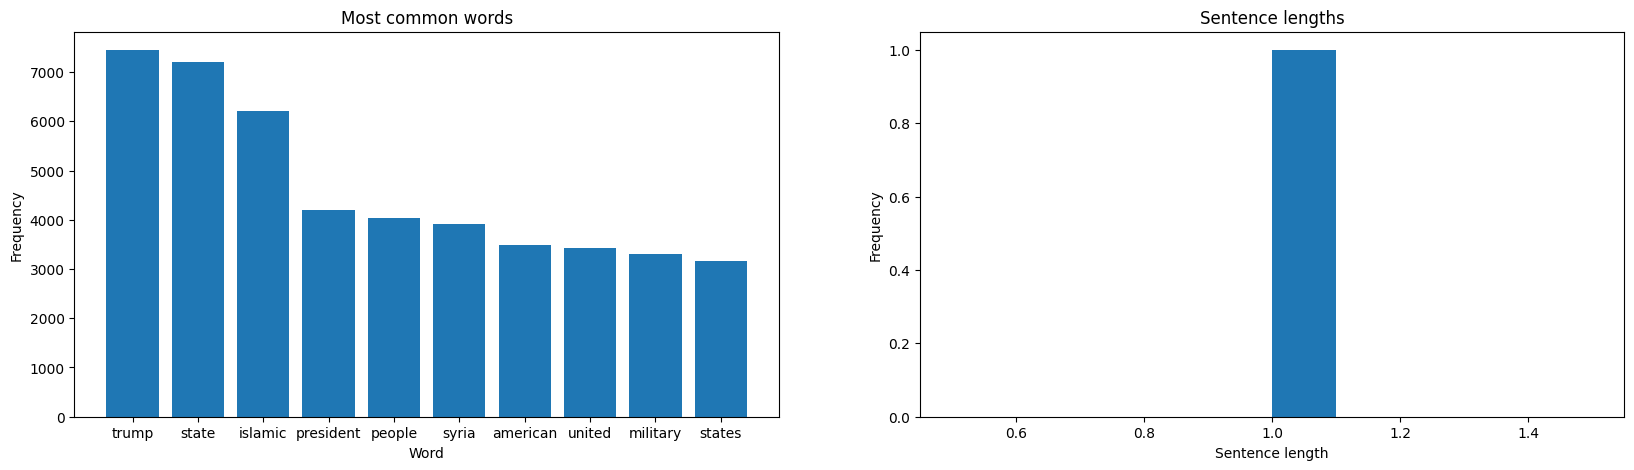

In [7]:
tokens = preprocess(corpus)
features = extract_features(tokens)
summarize_features(features)
plot_features(features)

In [8]:
import re
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load stopwords and lemmatizer
stop_words = stopwords.words('english')
stop_words.append('mr')
stop_words.append('said')
stop_words.append('u')
stop_words.append('also')
stop_words.append('one')
stop_words.append('year')
stop_words.append('new')
lemmatizer = WordNetLemmatizer()



# Preprocess corpus
corpus = re.sub('\n{3,}', '\n\n', corpus)  # remove excess newlines
corpus = re.sub('[^a-zA-Z\n]+', ' ', corpus)  # remove non-alphabetic characters
corpus = corpus.lower()  # lowercase all text
texts = [[lemmatizer.lemmatize(word) for word in document.split() if word not in stop_words] for document in corpus.split('\n\n\n')]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create multiple LDA models with different parameters
for num_topics in [5,]:
    for alpha in [0.1]:
        for eta in [0.01]:
            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=eta, iterations=100)

            # Calculate coherence score and perplexity
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            perplexity = lda_model.log_perplexity(corpus)
            lda_model.save(f'output_files/lda_{num_topics}.model')
            # Store summary in output file
            with open(f'output_files/output_{num_topics}_{alpha}_{eta}.txt', 'w') as f:
                f.write(f'Num Topics: {num_topics}\n')
                f.write(f'Alpha: {alpha}\n')
                f.write(f'Eta: {eta}\n')
                f.write(f'Coherence Score: {coherence_score}\n')
                f.write(f'Perplexity: {perplexity}\n')
                f.write('\n')
                f.write(f'Topics for LDA model with num_topics={num_topics}:\n\n')
                for topic_id, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
                    f.write(f'Topic {topic_id}:\n')
                    f.write(f'Word    Weight \n')
                    for word, weight in topic:
                        f.write(f'{word}:{weight:.3f}\n')
                    f.write('\n')

            # Visualize topics
            topics = lda_model.show_topics(formatted=False, num_words=10)
            for i, topic in enumerate(topics):
                words = [word[0] for word in topic[1]]
                weights = [word[1] for word in topic[1]]
                print(f'Topic {i+1}: {", ".join(words)}')
                print(f'Weights: {", ".join([str(weight) for weight in weights])}\n')


Topic 1: state, trump, islamic, american, would, syria, force, time, isi, attack
Weights: 0.011721429, 0.006688382, 0.005994497, 0.005016435, 0.004635975, 0.004419369, 0.004248466, 0.0041221497, 0.0038524393, 0.0037940552

Topic 2: state, trump, islamic, president, people, american, country, attack, united, time
Weights: 0.008047174, 0.006132768, 0.0059689744, 0.005652215, 0.0047921245, 0.004323222, 0.0041948617, 0.0036145358, 0.003299844, 0.003288015

Topic 3: state, trump, people, islamic, syria, president, official, time, would, american
Weights: 0.0099834595, 0.0070975916, 0.0057309, 0.005726126, 0.005506674, 0.004739306, 0.0044803643, 0.003905557, 0.0038724241, 0.003769764

Topic 4: state, trump, islamic, syria, time, american, military, attack, people, would
Weights: 0.011103991, 0.0065705515, 0.0057327235, 0.004553877, 0.0043697446, 0.00414898, 0.0040666834, 0.003854524, 0.0037137514, 0.0035452272

Topic 5: state, trump, islamic, president, american, united, time, would, force, 